# Background Remover

## Overview

To remove objects from images, there are several algorithms:

* **Clustering**
    * It usually partition the image into several clusters.
    * K-means is a well known method.
* **Thresholding**
    * The simplest method.
    * The key is to select a threshold value and then compare to each pixel.
* **Region Growing**
    * Mainly relies on the that the neighbors in same region should be similar.
* **Deep Learing**
    * It has an enormous achievement on this field.
    * Usually be implemented with convolutional layers.

All of them are very powerful and interesting, but we'll implement the remover with **deep learing**. 

## CNN (Convolutional Neural Network)

In deep learning, tasks about image are often solved with **CNN**. <br>
CNN has some powerful benefits:
* It takes important features from images, such as edges.
* In deep learning, it reduces the number of parameters, but has better performance.
* Network can be calculated on GPUs more faseter than on CPUs.

## Model Explain

There are many models for image segmentation made by well known organizations and researchers. <br>
We'll use **U-Net** in this example.

### U-Net

In traditional models, layers are usually connected to the next one. <br>
While more maxpooling layers inputs go through, the more features are lost.

U-Net solve this problem in a clever way. <br>
<img src="https://img-blog.csdn.net/20181022150306666?watermark/2/text/aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2dpdGh1Yl8zNjkyMzQxOA==/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70" width="70%">

It add outputs from encoder to layers of decoder directly, so the decoder can use more details.

## Prepare Dataset

Before building model, we should prepare our data first. <br>
We'll use images from **COCO dataset** to train the model.

Download train, validation and test dataset.

In [1]:
# !wget http://images.cocodataset.org/zips/train2017.zip data/
# !wget http://images.cocodataset.org/zips/val2017.zip data/
# !wget http://images.cocodataset.org/zips/test2017.zip data/

Extract all datasets.

In [2]:
# !unzip train2017.zip
# !unzip val2017.zip
# !unzip test2017.zip

To use COCO dataset for training, we need **annotation** files to get masks of segmentation.

In [3]:
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !unzip annotations_trainval2017.zip

Now, you should have three datasets and several json files in annotation folder. <br>
Next, we have to preprocess the images by creating mask images.

Load data information from annotations.

In [4]:
# from pycocotools.coco import COCO

In [5]:
# # annotations/instancesfree
# # {dataset}2017.json
# path = "annotations/instances_train2017.json"
# data = COCO(path)

We only need images that contain person.

In [6]:
# import numpy as np
# import cv2
# from os.path import join

In [7]:
# i = 0
# images, masks = [], []
# for imgId in data.getImgIds():
    
#     img = data.loadImgs(imgId)[0]
    
#     valid = False
#     anns = data.loadAnns(data.getAnnIds(imgId))

#     mask = np.zeros((img["height"], img["width"]), dtype=np.byte)
#     for ann in anns:
        
#         # category id of person is 1
#         if ann["category_id"] == 1:
#             seg = data.annToMask(ann)
#             mask += seg
#             valid = True
    
#     # if contains person
#     if valid:
        
#         file_name = img["file_name"]
#         # {dataset}2017
#         frame = cv2.imread(join("train2017", file_name))
#         # frames/{dataset}
#         cv2.imwrite(join("data/frames/train", file_name), frame)
#         # masks/{dataset}
#         cv2.imwrite(join("data/masks/train", file_name), mask)
#         i += 1

In [8]:
!ls -l data/frames/train | wc -l

64116


## Build Model

In this example, we'll use 6400 samples for training, 1600 for validation.

In [9]:
# input image shape
img_shape = (256, 256)
batch_size = 16
n_train = 500 * batch_size
n_val = 100 * batch_size

In [10]:
import cv2
import glob
from os.path import join, expanduser
import numpy as np

In [11]:
# this handles all requests for data
class generator:
    
    def __init__(self, frames_dir, masks_dir, img_shape, n_data=None, start=0):
        
        frames_path = glob.glob(join(frames_dir, "*.jpg"))
        self.frames_path = sorted(frames_path, key=lambda path: int(path.split('/')[-1].split('.')[0]))
        
        if masks_dir is None:
            self.masks_path = [""] * len(frames_path)
        else:
            masks_path = glob.glob(join(masks_dir, "*.jpg"))
            self.masks_path = sorted(masks_path, key=lambda path: int(path.split('/')[-1].split('.')[0]))
        
        # use all samples
        if n_data is None:
            n_data = len(frames_path)
        self.n_data = n_data
        
        self.img_shape = img_shape
        # used for shuffling
        self.order = np.arange(n_data) + start
        
    def __getitem__(self, key):
        
        if isinstance(key, slice):
            start, stop, step = key.indices(self.n_data)
            frames, masks = [], []
            
            for i in range(start, stop):
                frame, mask = self.get_data(
                    self.frames_path[self.order[i]], self.masks_path[self.order[i]]
                )
                frames.append(frame)
                masks.append(mask)
                
            return np.array(frames), np.array(masks)
        else:
            return self.get_data(
                self.frames_path[self.order[key]], self.masks_path[self.order[key]]
            )
    
    def __len__(self):
        return self.n_data
    
    def get_data(self, frame_path, mask_path):
        
        frame = cv2.imread(frame_path).astype(np.float32)
        mask = cv2.imread(mask_path)
        if mask is not None:
            mask = mask.astype(np.float32)[:,:,:1]
        
        return frame, mask
    
    def iterator(self, batch_size=None, shuffle=False):
        
        if batch_size is None :
            batch_size = self.n_data
        
        base = 0
        while True:
            
            if shuffle and base == 0:
                np.random.shuffle(self.order)
            
            # yield makes function iterateble
            yield self[base:base + batch_size]

            base += batch_size
            # ensure the iterator runs forever
            if base + batch_size > self.n_data:
                base = 0

In [12]:
train_frames_path = "data-256/frames/train"
train_masks_path = "data-256/masks/train"
train_generator = generator(
    train_frames_path, 
    train_masks_path, 
    img_shape, 
    n_train
)

val_frames_path = "data-256/frames/val"
val_masks_path = "data-256/masks/val"
val_generator = generator(
    val_frames_path, 
    val_masks_path, 
    img_shape, 
    n_val
)

Let's see what we have now.

In [13]:
import matplotlib.pyplot as plt

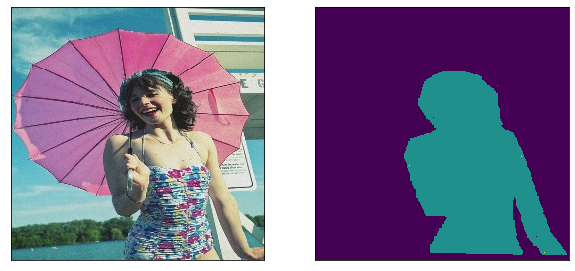

In [14]:
frame, mask = train_generator[0]
frame = frame.astype(np.int32)
mask = mask.astype(np.int32)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
# cv2 read image in BGR mode
plt.imshow(frame[:,:,::-1])

plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(mask[:,:,0])

plt.xticks([])
plt.yticks([])

plt.show()

segmentation-models is an library that provides several models for image segmentation. <br>
You can see more details on [github](https://github.com/qubvel/segmentation_models).

In [15]:
import segmentation_models as sm
import keras

model = sm.Unet("resnet34", input_shape=img_shape + (3, ))

optimizer = keras.optimizers.Adam(1e-4)
loss = sm.losses.bce_jaccard_loss
metrics = [sm.metrics.iou_score]

model.compile(optimizer, loss,  metrics)
model.summary()

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint("./best-unet.h5", 
        save_weights_only=True, 
        save_best_only=True, 
        mode="min"
    ), 
    keras.callbacks.ReduceLROnPlateau()
]

train_iter = train_generator.iterator(batch_size, True)
val_iter = val_generator.iterator(batch_size, True)

Train the model for 30 eopchs and save weights.

In [17]:
history = model.fit_generator(
    train_iter, 
    steps_per_epoch=len(train_generator) / batch_size, 
    epochs=30, 
    callbacks=callbacks, 
    validation_data=val_iter, 
    validation_steps=len(val_generator) / batch_size
)

model.save_weights("./last-unet.h5")

Epoch 1/30
500/500 [==============================] - 434s 869ms/step - loss: 0.7582 - iou_score: 0.4783 - val_loss: 0.5042 - val_iou_score: 0.6138
Epoch 2/30
500/500 [==============================] - 403s 806ms/step - loss: 0.4976 - iou_score: 0.6573 - val_loss: 0.3992 - val_iou_score: 0.6649
Epoch 3/30
500/500 [==============================] - 403s 806ms/step - loss: 0.4123 - iou_score: 0.7188 - val_loss: 0.3676 - val_iou_score: 0.6581
Epoch 4/30
500/500 [==============================] - 403s 807ms/step - loss: 0.3586 - iou_score: 0.7568 - val_loss: 0.6342 - val_iou_score: 0.6941
Epoch 5/30
500/500 [==============================] - 403s 806ms/step - loss: 0.3263 - iou_score: 0.7792 - val_loss: 0.3165 - val_iou_score: 0.7061
Epoch 6/30
500/500 [==============================] - 403s 806ms/step - loss: 0.3012 - iou_score: 0.7964 - val_loss: 0.4542 - val_iou_score: 0.7062
Epoch 7/30
500/500 [==============================] - 403s 806ms/step - loss: 0.2741 - iou_score: 0.8145 - val_l

In [18]:
val_loss, val_iou_score = model.evaluate_generator(
    val_iter, 
    steps=n_val / batch_size
)
print(f"val_loss: {val_loss:1.4f} - val_iou_score: {val_iou_score:1.4f}")

val_loss: 0.5810 - val_iou_score: 0.7222


Visualize training history

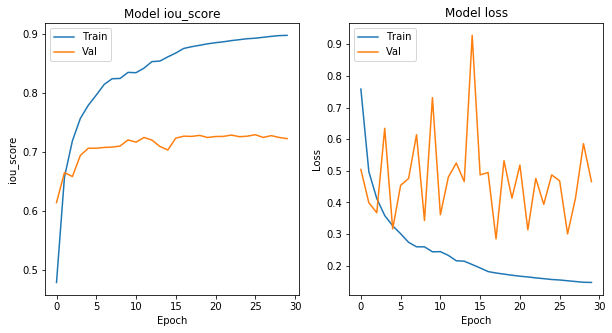

In [19]:
# plot training and validation iou_score values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Read only frames from test dataset.

In [20]:
n_test = 1000
n_show = 3

# there is no annotations for test dataset, 
# so we split val dataset into validation and test
test_generator = generator(
    val_frames_path, 
    val_masks_path, 
    img_shape, 
    n_test, 
    n_val
)
test_iter = test_generator.iterator(n_show, True)

Visualize results with matplotlib.

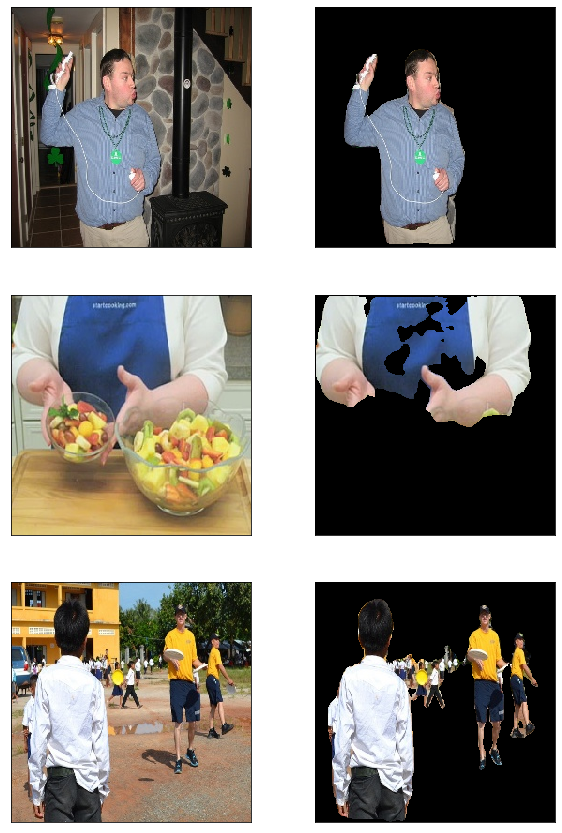

In [21]:
frames, _ = next(test_iter)
frames = frames.astype(np.int32)
res = model.predict(frames)

n_show = 3
plt.figure(figsize=(10, 5 * n_show))

for i in range(n_show):

    frame = frames[i][:,:,::-1]
    
    plt.subplot(n_show, 2, i * 2 + 1)
    plt.imshow(frame)
    
    plt.xticks([])
    plt.yticks([])

    # convert mask into three-chennel image
    mask = np.repeat(res[i], 3, axis=2)
    # set average value as treshold to cut off the foreground
    frame[mask < 0.5] *= 0

    plt.subplot(n_show, 2, i * 2 + 2)
    plt.imshow(frame)
    
    plt.xticks([])
    plt.yticks([])
    
plt.show()